Import Libraries

In [1]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
import requests
from PIL import Image
from io import BytesIO

import copy

In [3]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [4]:
numb_batch = 64

Getting Data

In [5]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

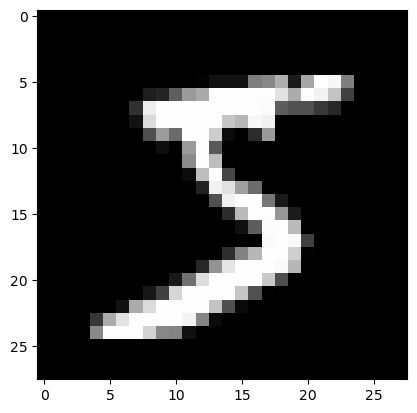

In [6]:
plt.imshow(train_data[0][0][0] , cmap="gray")

Creating the Model

In [7]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

Validating the Model

In [8]:
# def validate(model, data):
#     total = 0
#     correct = 0
#     for i, (images, labels) in enumerate(data):
#         images = images.cuda()
#         x = model(images)
#         value, pred = torch.max(x,1)
#         pred = pred.data.cpu()
#         total += x.size(0)
#         correct += torch.sum(pred == labels)
#     return correct*100./total



def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        # images = images.cuda()  # Bu satırı kaldırın
        # GPU yerine CPU'ya taşıma
        # images = images.cpu()  # Gerek yok, veri zaten CPU'da olacak
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels.cpu())  # labels'i de CPU'ya taşıdık
    return correct*100./total


Training Function

In [9]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

GPU Availability

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

No Cuda Available


device(type='cpu')

Training the Model

Saving Best Model with Accuracy:  95.45999908447266
Epoch: 1 Accuracy : 95.45999908447266 %
Saving Best Model with Accuracy:  97.12999725341797
Epoch: 2 Accuracy : 97.12999725341797 %
Saving Best Model with Accuracy:  97.63999938964844
Epoch: 3 Accuracy : 97.63999938964844 %
Saving Best Model with Accuracy:  98.02999877929688
Epoch: 4 Accuracy : 98.02999877929688 %
Saving Best Model with Accuracy:  98.44000244140625
Epoch: 5 Accuracy : 98.44000244140625 %
Saving Best Model with Accuracy:  98.79000091552734
Epoch: 6 Accuracy : 98.79000091552734 %
Saving Best Model with Accuracy:  98.8499984741211
Epoch: 7 Accuracy : 98.8499984741211 %
Epoch: 8 Accuracy : 98.79000091552734 %
Epoch: 9 Accuracy : 98.72000122070312 %
Epoch: 10 Accuracy : 98.80000305175781 %
Epoch: 11 Accuracy : 98.73999786376953 %
Saving Best Model with Accuracy:  98.9000015258789
Epoch: 12 Accuracy : 98.9000015258789 %
Saving Best Model with Accuracy:  99.02999877929688
Epoch: 13 Accuracy : 99.02999877929688 %
Epoch: 14 Ac

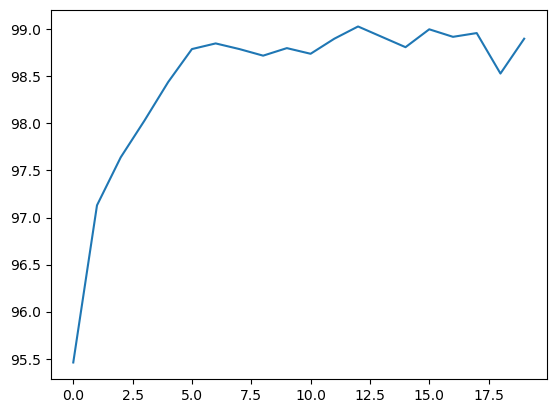

In [11]:
lenet = train(20 , device=device)  ### device=device

Saving the model

In [12]:
torch.save(lenet.state_dict(), "lenet.pth")

Loading the saved model

In [13]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("lenet.pth"))
lenet.eval()


Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

Creating the Function to test validation data

In [14]:
# def predict_dl(model, data):
#     y_pred = []
#     y_true = []
#     for i, (images, labels) in enumerate(data):
#         images = images.cuda()
#         x = model(images)
#         value, pred = torch.max(x, 1)
#         pred = pred.data.cpu()
#         y_pred.extend(list(pred.numpy()))
#         y_true.extend(list(labels.numpy()))
#     return np.array(y_pred), np.array(y_true)
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        # images = images.cuda()  # Bu satırı kaldırın
        # GPU yerine CPU'ya taşıma
        # images = images.cpu()  # Gerek yok, veri zaten CPU'da olacak
        x = model(images)
        value, pred = torch.max(x, 1)
        y_pred.extend(pred.tolist())
        y_true.extend(labels.tolist())
    return y_pred, y_true


In [15]:
y_pred, y_true = predict_dl(lenet, val_dl)

Confusion Matrix

In [16]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,974,1,1,0,0,0,1,1,2,0
1,0,1132,0,0,0,0,0,0,3,0
2,0,0,1032,0,0,0,0,0,0,0
3,1,0,4,995,0,3,0,3,1,3
4,0,0,0,0,972,0,5,0,0,5
5,0,0,0,2,0,887,1,0,0,2
6,2,2,1,0,3,7,943,0,0,0
7,0,3,7,0,0,0,0,1013,1,4
8,2,0,2,5,0,1,1,2,958,3
9,0,0,0,1,8,2,0,1,0,997


Define Inference function to get prediction for any given image

In [17]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

Getting the image from the web and showing the image

In [18]:
path = "https://as1.ftcdn.net/v2/jpg/05/22/11/98/1000_F_522119800_fw1rdxPF1AVsgGjpVVkP1ma9o7XenJjI.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

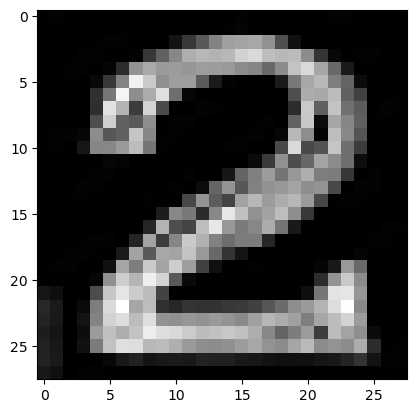

In [19]:
plt.imshow(x.squeeze(-1), cmap="gray")

Predictions

In [20]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")


Predicted: 2, Prob: 100.0 %


In [21]:
pred

array([[1.9635421e-10, 8.8152966e-12, 1.0000000e+00, 1.6092584e-10,
        3.0205071e-19, 7.1636603e-22, 3.7880502e-16, 2.8327675e-11,
        3.7722594e-09, 1.0735915e-17]], dtype=float32)